In [1]:
import torch
import numpy as np
import os
import shutil
from tqdm import tqdm
import yaml

import sys
import os
curr_dir = os.getcwd()
if 's94zalek_hpc' in curr_dir:
    user_name = 's94zalek_hpc'
else:
    user_name = 's94zalek'
sys.path.append(f'/home/{user_name}/shape_matching')

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

# training / evaluation
from torch.utils.tensorboard import SummaryWriter
from my_code.diffusion_training_sign_corr.train_model import train_epoch
from my_code.diffusion_training_sign_corr.validate_model import validate_epoch

import my_code.diffusion_training_sign_corr.data_loading as data_loading

from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset
import networks.diffusion_network as diffusion_network



# configuration
experiment_name = 'test_signCorr_noAug'
checkpoint_name = 'checkpoint_85'

### config
exp_base_folder = f'/home/s94zalek_hpc/shape_matching/my_code/experiments/{experiment_name}'
with open(f'{exp_base_folder}/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


### model
model = DiagConditionedUnet(config["model_params"]).to('cuda')
model.load_state_dict(torch.load(f"{exp_base_folder}/checkpoints/{checkpoint_name}.pt"))
model = model.to('cuda')
 
### Sign correction network
sign_corr_net = diffusion_network.DiffusionNet(
    in_channels=config["model_params"]["sample_size"],
    out_channels=config["model_params"]["sample_size"] // config["evecs_per_support"],
    cache_dir=None,
    input_type=config["net_input_type"],
    k_eig=128,
    n_block=6
    ).to('cuda')
sign_corr_net.load_state_dict(torch.load(config["sign_net_path"]))


### sample the model
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True) 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
### test dataset
dataset_name = 'FAUST_orig'

test_dataset = data_loading.get_val_dataset(
    dataset_name, 'train', config["model_params"]["sample_size"]
    )[1]

# return the subset
# subset_indices = list(range(len(test_dataset))) #[10:]
# test_dataset = torch.utils.data.Subset(test_dataset, subset_indices)


Loading base dataset: 100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:17<00:00,  4.51it/s]


In [3]:
import my_code.diffusion_training_sign_corr.sample_model as sample_model
import my_code.diffusion_training_sign_corr.evaluate_samples as evaluate_samples


with torch.no_grad():
    
    fmap_sampled = sample_model.sample_dataset(model, test_dataset, noise_scheduler)

Sampling test dataset, device = cuda:0


Denoising...: 100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 53.16it/s]


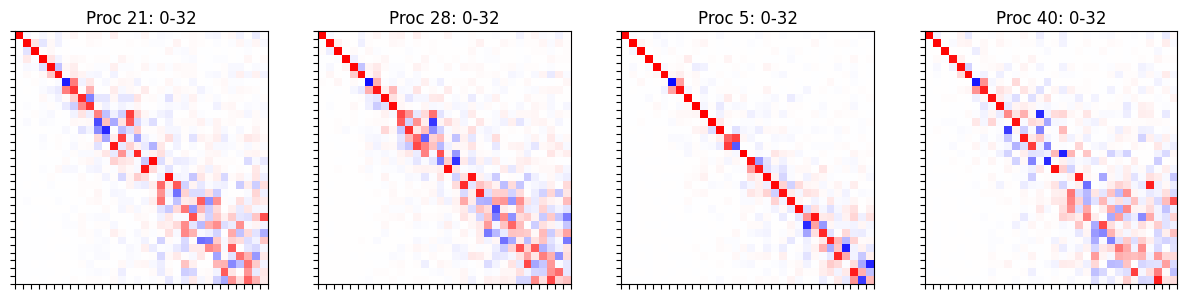

In [4]:
import my_code.utils.plotting_utils as plotting_utils
import matplotlib.pyplot as plt
    
l = 0
h = 32

# get 4 random indices
idxs = np.random.randint(0, fmap_sampled.shape[0], 4)

fig, axs = plt.subplots(1, 4, figsize=(15, 8))

plotting_utils.plot_Cxy(fig, axs[0], fmap_sampled[idxs[0], 0],
                        f'Proc {idxs[0]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], fmap_sampled[idxs[1], 0],
                        f'Proc {idxs[1]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], fmap_sampled[idxs[2], 0],
                        f'Proc {idxs[2]}', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[3], fmap_sampled[idxs[3], 0],
                        f'Proc {idxs[3]}', l, h, show_grid=False, show_colorbar=False)

plt.show()

In [29]:
import importlib
importlib.reload(evaluate_samples)

<module 'my_code.diffusion_training_sign_corr.evaluate_samples' from '/home/s94zalek_hpc/shape_matching/my_code/diffusion_training_sign_corr/evaluate_samples.py'>

Calculating metrics...: 100%|██████████████████████████████████████████████████████████████████████████████| 80/80 [00:24<00:00,  3.33it/s]

{'auc': 0.449, 'geo_err_mean': 6.7, 'geo_err_meanByShape_median': 6.1, 'geo_err_meanByShape_max': 12.8, 'geo_err_meanByShape_min': 3.2, 'geo_err_ratio_mean': 3.68, 'geo_err_ratio_median': 2.92, 'geo_err_ratio_max': 45.37, 'geo_err_ratio_min': 1.45, 'geo_err_ratio_corr_mean': 3.68, 'geo_err_ratio_corr_median': 2.92, 'geo_err_ratio_corr_max': 45.37, 'geo_err_ratio_corr_min': 1.45, 'mse_mean': 21.37, 'mse_median': 20.69, 'mse_max': 41.98, 'mse_min': 6.78}


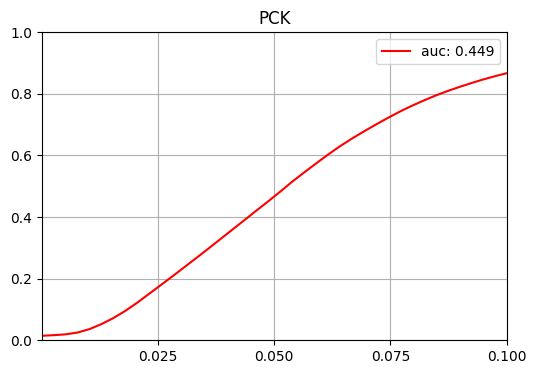

In [30]:
## calculate metrics and pck
metrics_payload, fig_pck = evaluate_samples.calculate_metrics(
    fmap_sampled,
    test_dataset,
    sign_corr_net
)

print(metrics_payload)

# show the pck figure
fig_pck.show()